In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from glob import glob
import cv2
import os
print(os.listdir("../input"))

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Any results you write to the current directory are saved as output.

['test', 'train', 'sample_submission.csv']


In [2]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import os
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


# Data Visualization

Visualize the dataset (the different classes)

In [3]:
print(os.listdir("../input"))

['test', 'train', 'sample_submission.csv']


In [4]:
data_dir = '../input/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [5]:
sample_submission.head()

file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet
2  007b3da8b.png  Sugar beet
3  0086a6340.png  Sugar beet
4  00c47e980.png  Sugar beet

In [6]:
Categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [7]:
for category in Categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [8]:
train = []
for category_id, category in enumerate(Categories):
    for file in os.listdir(os.path.join(train_dir, category)): 
        #use the folder path as name then for categoy it's based on file structure
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head()

file  category_id     category
0  train/Black-grass/abe0f4751.png            0  Black-grass
1  train/Black-grass/c1a625098.png            0  Black-grass
2  train/Black-grass/6b9ebf8cc.png            0  Black-grass
3  train/Black-grass/898ecfa78.png            0  Black-grass
4  train/Black-grass/eac39cfa8.png            0  Black-grass

In [9]:
train.tail()

file  category_id    category
4745  train/Sugar beet/e4a149c23.png           11  Sugar beet
4746  train/Sugar beet/5582aca59.png           11  Sugar beet
4747  train/Sugar beet/b2b9468af.png           11  Sugar beet
4748  train/Sugar beet/1ec9ab1b8.png           11  Sugar beet
4749  train/Sugar beet/6d99bec4e.png           11  Sugar beet

In [10]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head()

filepath           file
0  test/36d62bf36.png  36d62bf36.png
1  test/de0b79659.png  de0b79659.png
2  test/41f1c3cdb.png  41f1c3cdb.png
3  test/39d569be4.png  39d569be4.png
4  test/b2706e2b3.png  b2706e2b3.png

## Images 

In [ ]:
def create_mask_for_plant(img):
    image_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(img):
    mask = create_mask_for_plant(img)
    output = cv2.bitwise_and(img, img, mask = mask)
    return output

def sharpen_image(img):
    image_blurred = cv2.GaussianBlur(img, (0, 0), 3)
    image_sharp = cv2.addWeighted(img, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [13]:
images = []
labels = []

images_per_class = {}
for class_folder_name in os.listdir(train_dir):
#     print("_", end = '')
    class_folder_path = os.path.join(train_dir, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
#         print(".", end = '')
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)
        
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (150, 150))
        img = segment_plant(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (45,45))
        
        img = img.flatten()
        images.append(img)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

## Visualizing Dataset
### Number of images for each class

In [14]:
for key,value in images_per_class.items():
    print("{0} has {1} samples".format(key, len(value)))

Fat Hen has 475 samples
Black-grass has 263 samples
Cleavers has 287 samples
Small-flowered Cranesbill has 496 samples
Sugar beet has 385 samples
Common Chickweed has 611 samples
Maize has 221 samples
Loose Silky-bent has 654 samples
Common wheat has 221 samples
Scentless Mayweed has 516 samples
Shepherds Purse has 231 samples
Charlock has 390 samples


In [18]:
# plt.imshow(np.reshape(images[734], (45,45)), cmap="gray")

### Sample Images for each class

In [16]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n += 1        

Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet


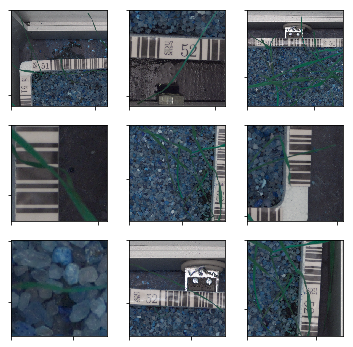

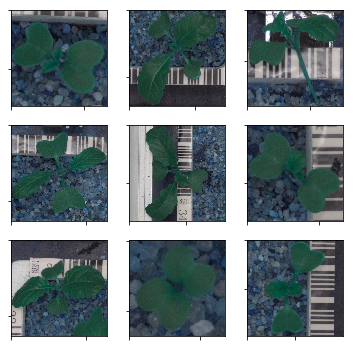

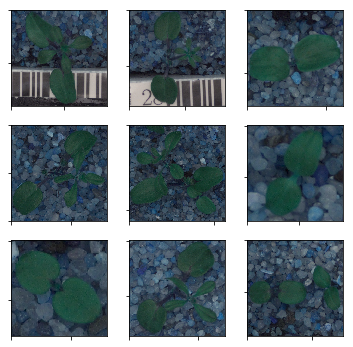

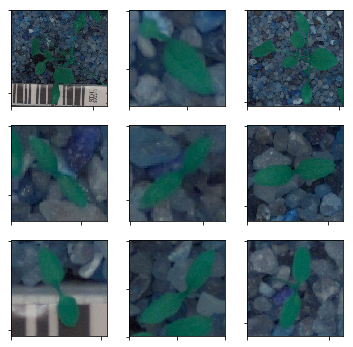

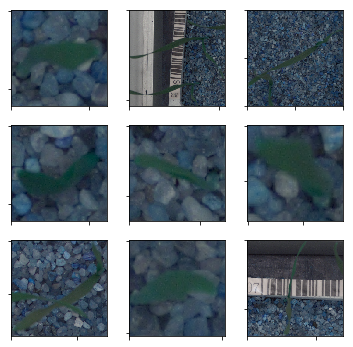

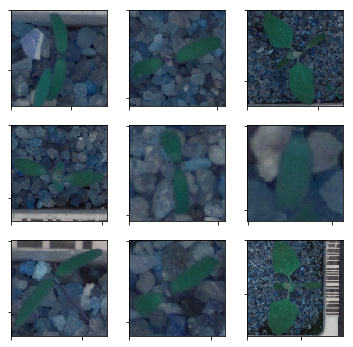

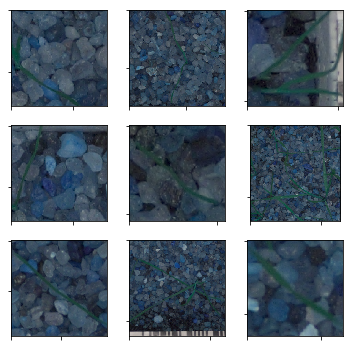

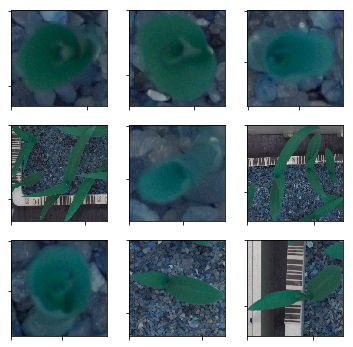

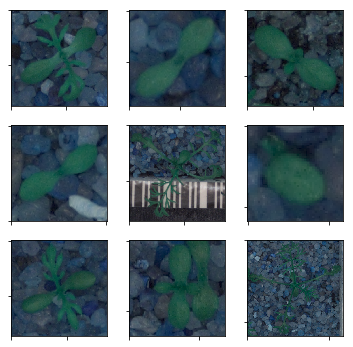

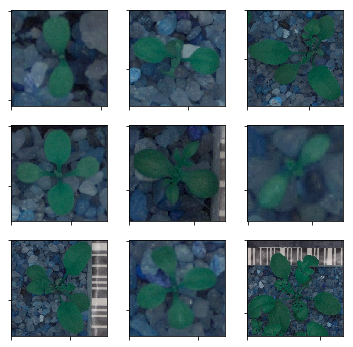

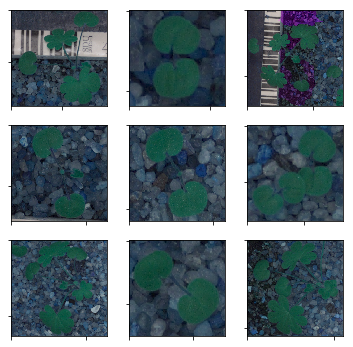

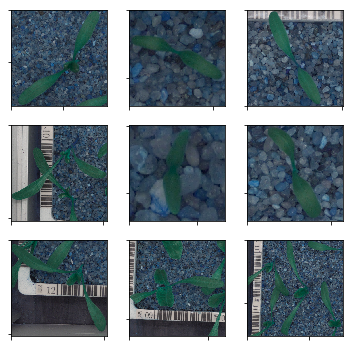

In [17]:
for category in Categories:
    print(category)
    plot_for_class(category)


In [20]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

#import opencv2 as cv

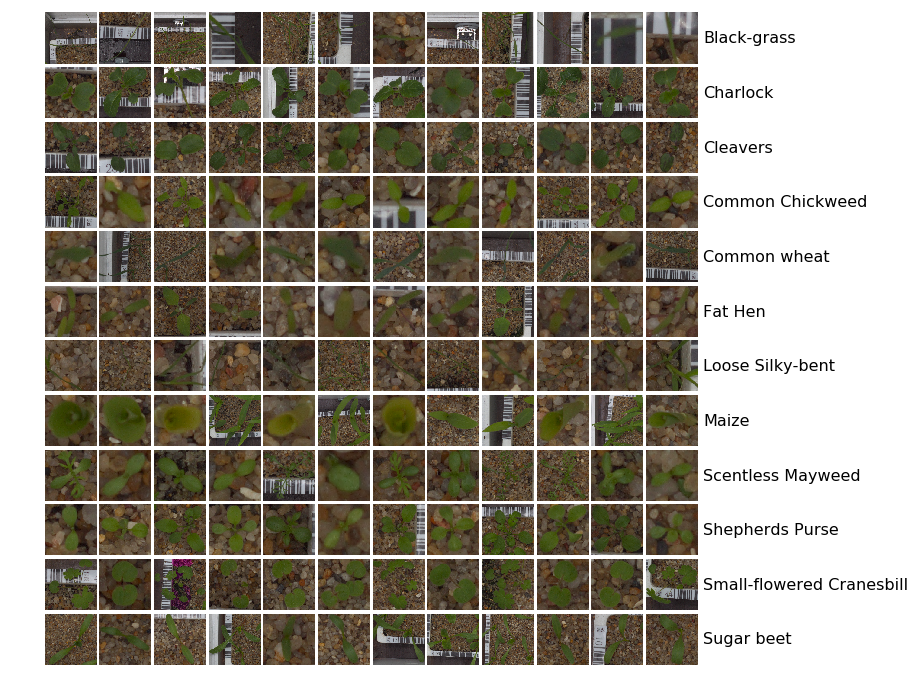

In [21]:
fig = plt.figure(1, figsize=(len(Categories), len(Categories)))
grid = ImageGrid(fig, 111, nrows_ncols=(len(Categories), len(Categories)), axes_pad=0.05)
i = 0
for category_id, category in enumerate(Categories):
    for filepath in train[train['category'] == category]['file'].values[:len(Categories)]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % len(Categories) == len(Categories) - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

# Image Masks


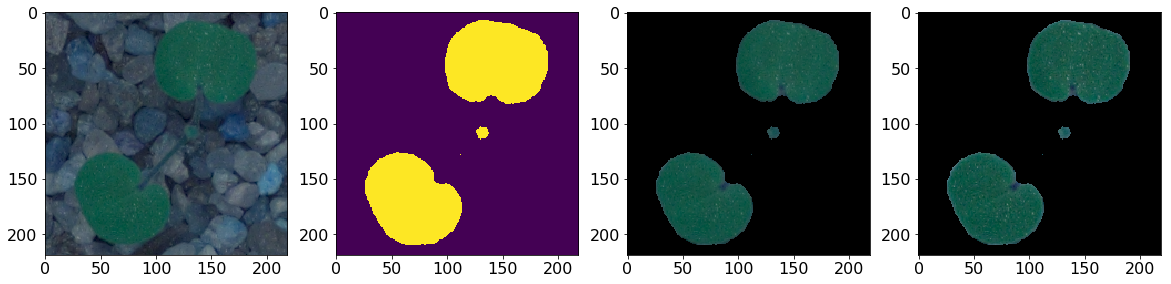

In [22]:
# Test image to see the changes
img = images_per_class["Small-flowered Cranesbill"][97]

image_mask = create_mask_for_plant(img)
image_segmented = segment_plant(img)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(img)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

### Our visualization of image masking for each class

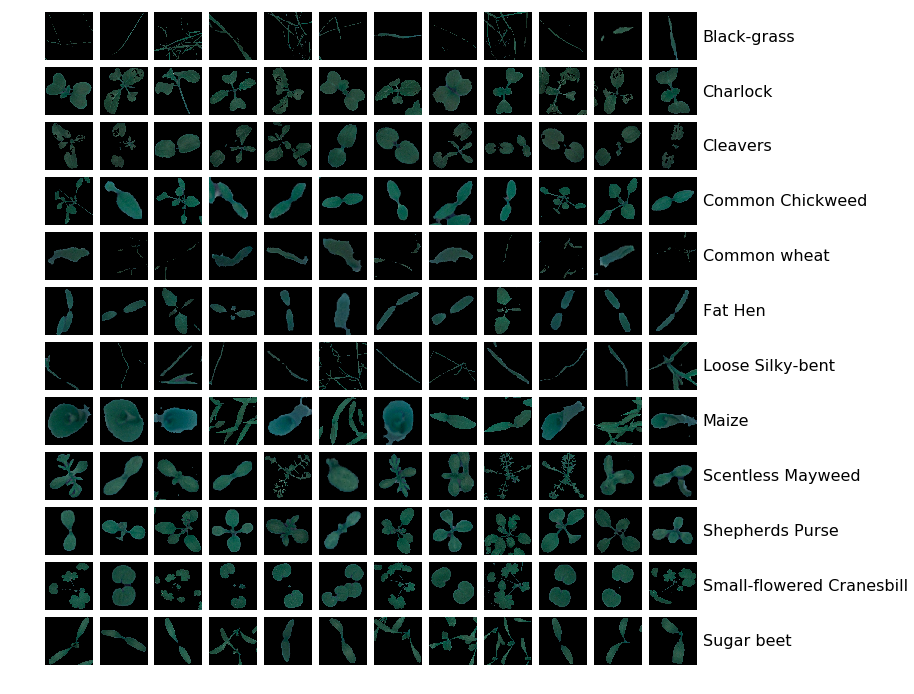

In [23]:
# Test image to see the changes
img = images_per_class["Small-flowered Cranesbill"][87]

image_mask = create_mask_for_plant(img)
image_segmented = segment_plant(img)
image_sharpen = sharpen_image(image_segmented)

fig = plt.figure(1, figsize=(len(Categories), len(Categories)))
grid = ImageGrid(fig, 111, nrows_ncols=(len(Categories), len(Categories)), axes_pad=0.1)
i = 0
for category_id, category in enumerate(Categories):
    for j in range(12):
        ax = grid[i]
        img = images_per_class[category][j]
#         img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
        image_segmented = segment_plant(img)
        image_sharpen = sharpen_image(image_segmented)
#         print(image_shapen.shape)
#         img = cv2.resize(image_sharpen, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        img = cv2.resize(image_sharpen, (224, 224))
        img = image.img_to_array(img)
#         img = img.reshape(-1,img.shape[1])
#         print(img.shape)
        ax.imshow(img/255.)
        ax.axis('off')
        if i % len(Categories) == len(Categories) - 1:
            ax.text(250, 112, category, verticalalignment='center')
        i += 1
        
    
    
plt.show();


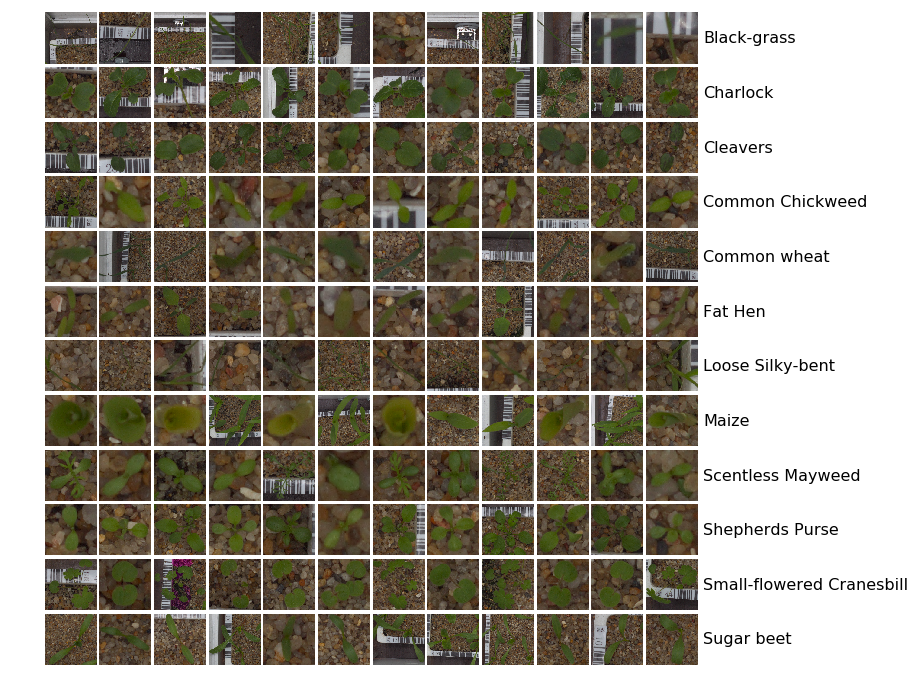

In [31]:
fig = plt.figure(1, figsize=(len(Categories), len(Categories)))
grid = ImageGrid(fig, 111, nrows_ncols=(len(Categories), len(Categories)), axes_pad=0.05)
i = 0
for category_id, category in enumerate(Categories):
#     print (category)
    for filepath in train[train['category'] == category]['file'].values[:len(Categories)]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))/255.
#         image_mask = create_mask_for_plant(img)
#         image_sharpen = sharpen_image(segment_plant(img))
#         print(img.shape)
        ax.imshow(img)
        ax.axis('off')
        if i % len(Categories) == len(Categories) - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();



## For Sharpened Images

### PCA 

In [33]:
#for sharpened images
images = []
labels = []

images_per_class = {}
for class_folder_name in os.listdir(train_dir):
#     print("_", end = '')
    class_folder_path = os.path.join(train_dir, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
#         print(".", end = '')
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)
        
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (150, 150))
        img = sharpen_image(segment_plant(img)) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (45,45))
        
        img = img.flatten()
        images.append(img)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

In [34]:
pca = PCA(n_components=180)
images_scaled = StandardScaler().fit_transform(images)
pca_result = pca.fit_transform(images_scaled)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### T-SNE

In [35]:
def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')
    
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()


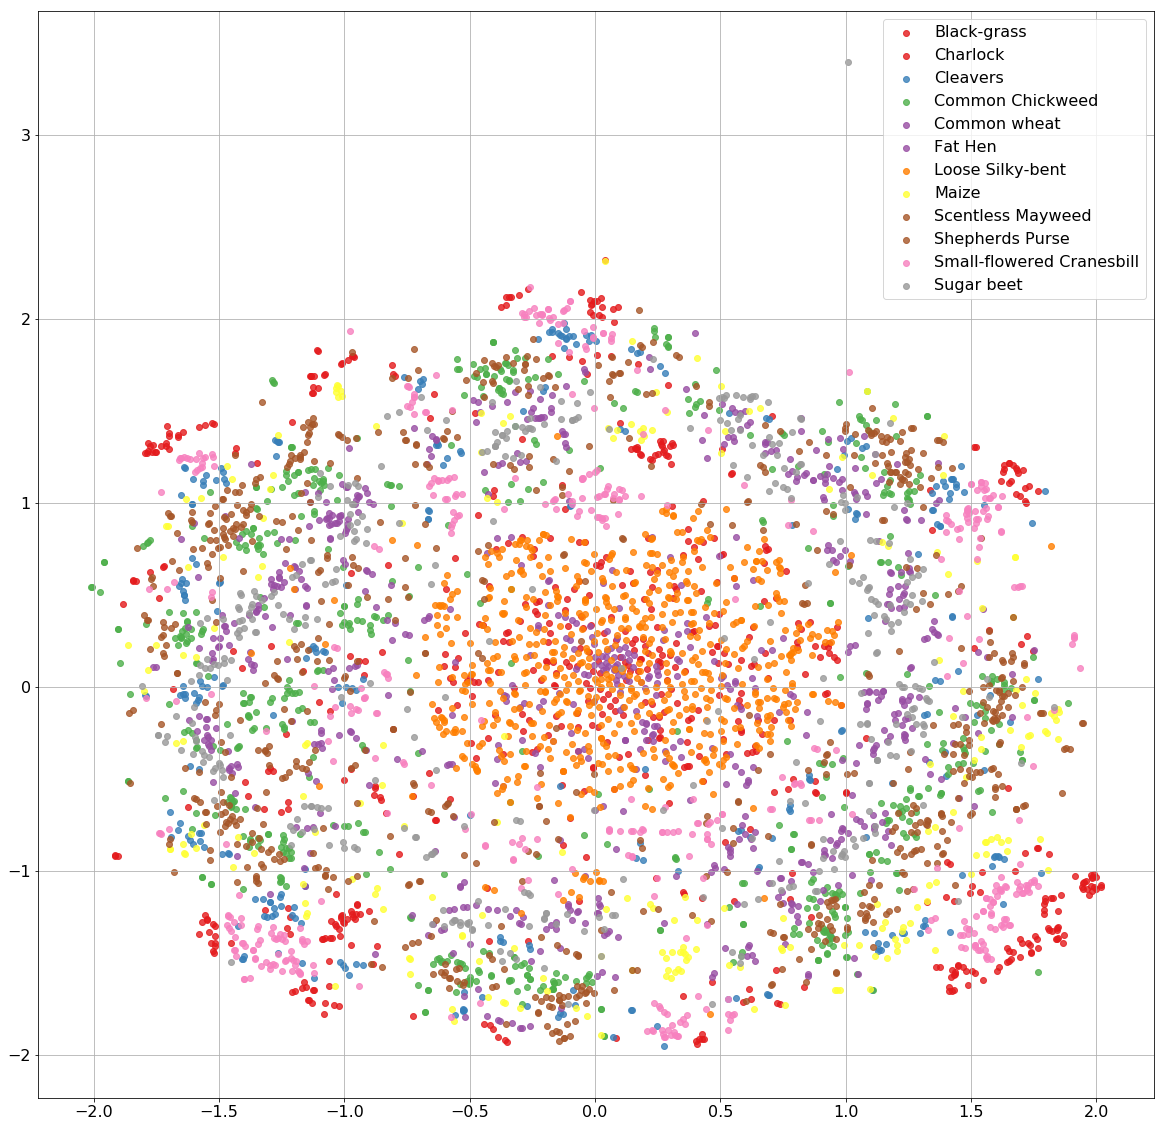

In [36]:

label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])

tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
visualize_scatter(tsne_result_scaled, label_ids)

In [44]:

# visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)

## For Original Images

In [45]:
#for original images
images = []
labels = []

images_per_class = {}
for class_folder_name in os.listdir(train_dir):
#     print("_", end = '')
    class_folder_path = os.path.join(train_dir, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
#         print(".", end = '')
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)
        
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (150, 150))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (45,45))
        
        img = img.flatten()
        images.append(img)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

### PCA

In [46]:
pca = PCA(n_components=180)
images_scaled = StandardScaler().fit_transform(images)
pca_result = pca.fit_transform(images_scaled)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### T-SNE

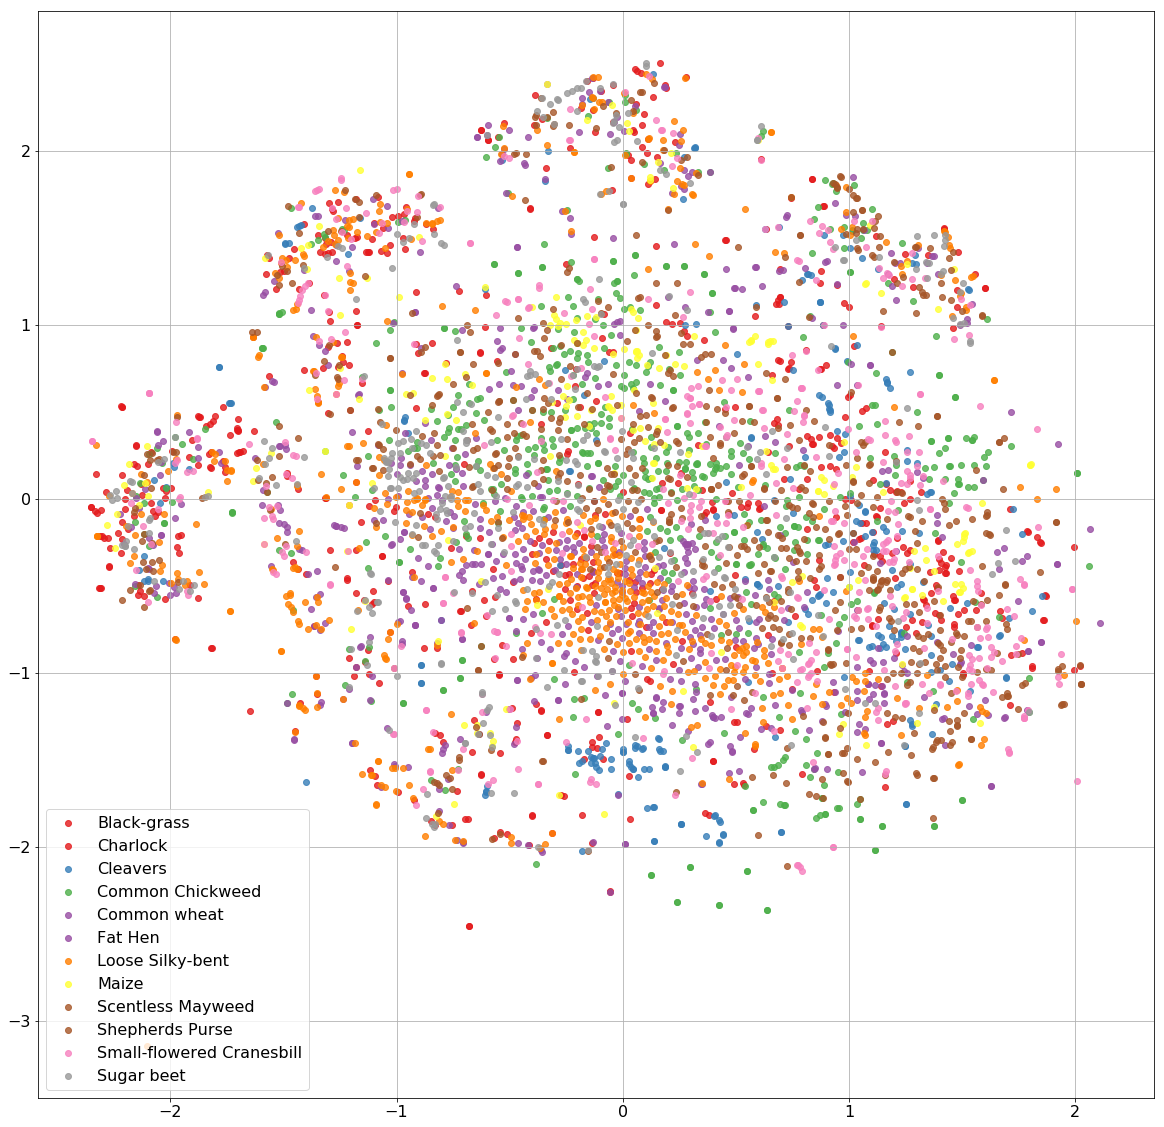

In [47]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])

tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
visualize_scatter(tsne_result_scaled, label_ids)

In [48]:

visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)

ValueError: cannot reshape array of size 6075 into shape (45,45)

## References
We modified code from the following sources for visualization of Data:
- https://www.kaggle.com/gaborfodor/seedlings-pretrained-keras-models (Visualization -  Image Grid)
- https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision (Image Masking)
- https://www.kaggle.com/gaborvecsei/plants-t-sne (Visualization - T-SNE)
